# 1. Wholesale Customers Dataset

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.  
There are 7 features: 'Channel', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper' 'Delicassen' and 1 target: 'Region'.  

1)	FRESH: annual spending (m.u.) on fresh products (Continuous);
2)	MILK: annual spending (m.u.) on milk products (Continuous);
3)	GROCERY: annual spending (m.u.)on grocery products (Continuous);
4)	FROZEN: annual spending (m.u.)on frozen products (Continuous);
5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous);
6)	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
7)	CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal);
8)	REGION: customersâ€™ Region â€“ Lisnon, Oporto or Otminal) (Nominal);

Dataset: https://archive.ics.uci.edu/dataset/292/wholesale+customers 

**Decomposition methods:**
1) PCA
2) t-SNE

**Clustering methods:**
1) k-means  
2) Hierarchical clustering  
3) DBScan  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# dataset
# pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator

In [2]:
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
  
# variable information 
info = wholesale_customers.variables
print("Variable info: ")
display(info)
        
# data
X = wholesale_customers.data.features.rename(columns={'Detergents_Paper': 'Det_Paper', 'Delicassen': 'Deli'}) # shorten names 
print("Features shape: ", X.shape)
# Notes: Channel is categorical
display(X.describe())

y = wholesale_customers.data.targets 
print("Target shape: ", y.shape)

Variable info: 


,name,role,type,demographic,description,units,missing_values
0,Channel,Feature,Categorical,None,None,None,no
1,Region,Target,Categorical,None,None,None,no
2,Fresh,Feature,Integer,None,None,None,no
3,Milk,Feature,Integer,None,None,None,no
4,Grocery,Feature,Integer,None,None,None,no
5,Frozen,Feature,Integer,None,None,None,no
6,Detergents_Paper,Feature,Integer,None,None,None,no
7,Delicassen,Feature,Integer,None,None,None,no


Features shape:  (440, 7)


,Channel,Fresh,Milk,Grocery,Frozen,Det_Paper,Deli
count,440.00,440.00,440.00,440.00,440.00,440.00,440.00
mean,1.32,12000.30,5796.27,7951.28,3071.93,2881.49,1524.87
std,0.47,12647.33,7380.38,9503.16,4854.67,4767.85,2820.11
min,1.00,3.00,55.00,3.00,25.00,3.00,3.00
25%,1.00,3127.75,1533.00,2153.00,742.25,256.75,408.25
50%,1.00,8504.00,3627.00,4755.50,1526.00,816.50,965.50
75%,2.00,16933.75,7190.25,10655.75,3554.25,3922.00,1820.25
max,2.00,112151.00,73498.00,92780.00,60869.00,40827.00,47943.00


Target shape:  (440, 1)


# 2. Data exploration
## Frequency distribution of features

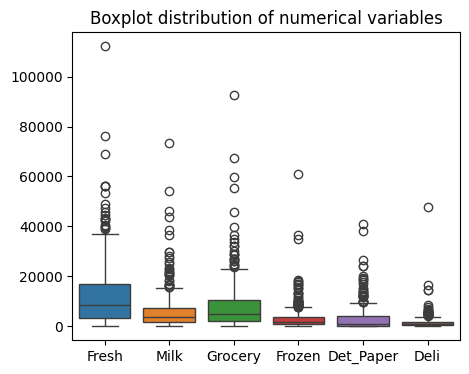

In [3]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=X.drop(['Channel'], axis=1))
plt.title('Boxplot distribution of numerical variables')
plt.show()

- Less is spent on Deli as compared to the others

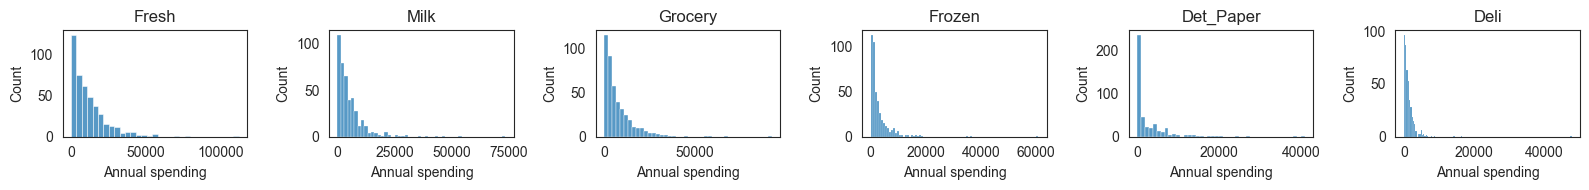

In [4]:
sns.set_style(style='white')
fig, axes = plt.subplots(1, len(X.columns)-1, figsize=(16, 2))
axes = axes.flatten()

for i, col in enumerate(X.iloc[:,1:].columns):
    sns.histplot(x=X[col], ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Annual spending')

plt.tight_layout()
plt.show()

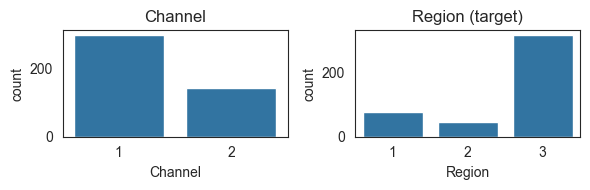

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2))

sns.countplot(data=X, x='Channel', ax=axes[0])
axes[0].set_title('Channel')

sns.countplot(data=y, x='Region', ax=axes[1])
axes[1].set_title('Region (target)')

plt.tight_layout()
plt.show()

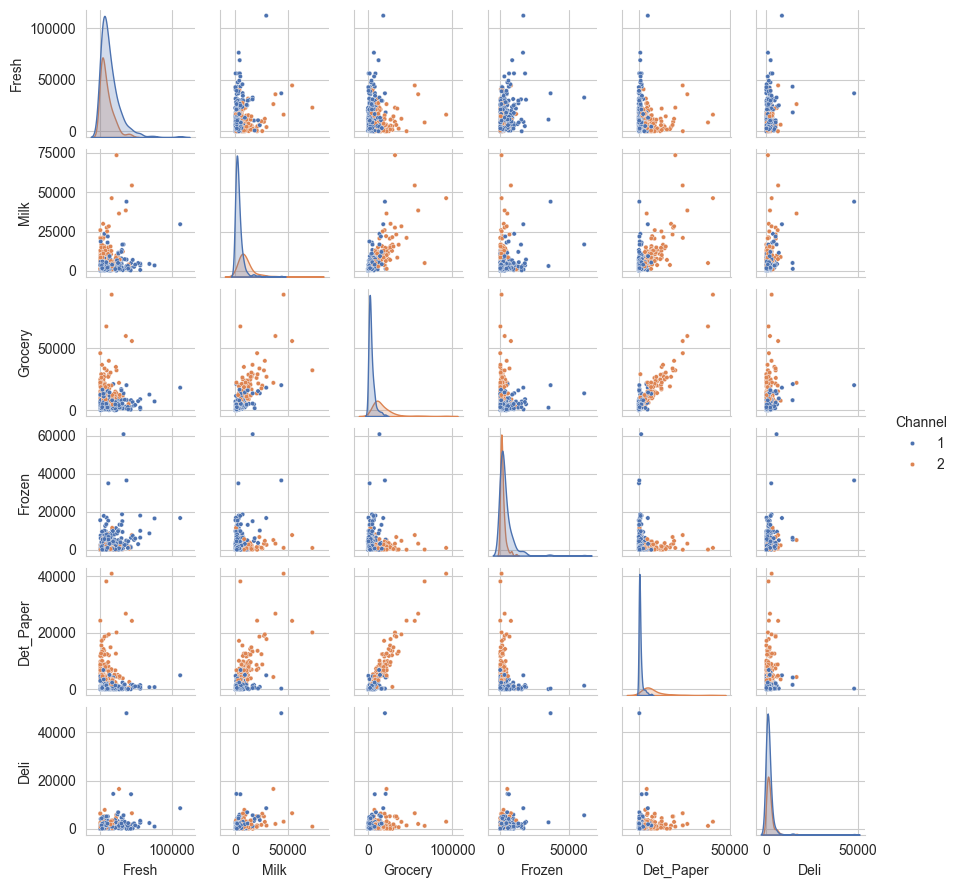

In [6]:
# scatterplot to show relationship and distribution
sns.set_style(style='whitegrid')
with sns.plotting_context(rc={"axes.labelsize":10}):
    sns.pairplot(X, height = 1.5, plot_kws={"s": 10}, hue="Channel", palette="deep")
    plt.show();

- features are right skewed, indicating that there are some outliers that are high spenders  
- Channel 2 tends to purchase more Milk, Grocery, and Det_Paper

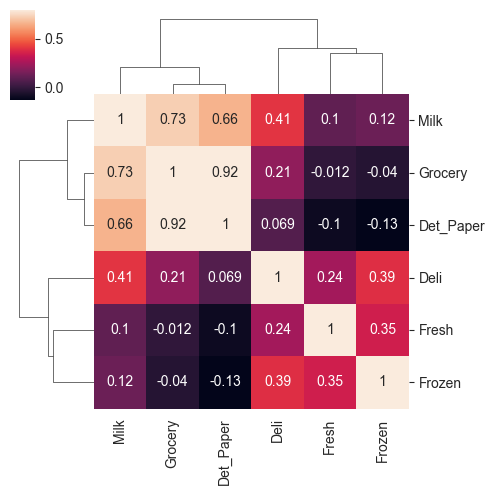

In [7]:
# correlation matrix
corrmat = X.iloc[:,1:].corr()
sns.clustermap(corrmat, vmax=.8, figsize = (5, 5), annot=True);

- strong positive correlation between Grocery and Det_Paper, clients who spend more on groceries also tend to spend on detergents and paper
- Milk also shows a positive correlation with Grocery and Det_Paper
- Deli do not show as strong a correlation with other variables, which might indicate that it is independent of other variables

# 3. Dimensionality reduction
## PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Channel,0.43,-0.21,0.02,-0.09,-0.86,0.13,0.02
Fresh,-0.03,0.51,-0.81,-0.25,-0.13,-0.03,-0.03
Milk,0.47,0.21,0.06,-0.06,0.32,0.79,-0.04
Grocery,0.54,-0.01,-0.11,0.13,0.21,-0.35,0.72
Frozen,-0.03,0.59,0.18,0.75,-0.23,-0.00,-0.01
Det_Paper,0.52,-0.12,-0.14,0.20,0.19,-0.37,-0.69
Deli,0.16,0.53,0.53,-0.56,-0.03,-0.31,-0.08


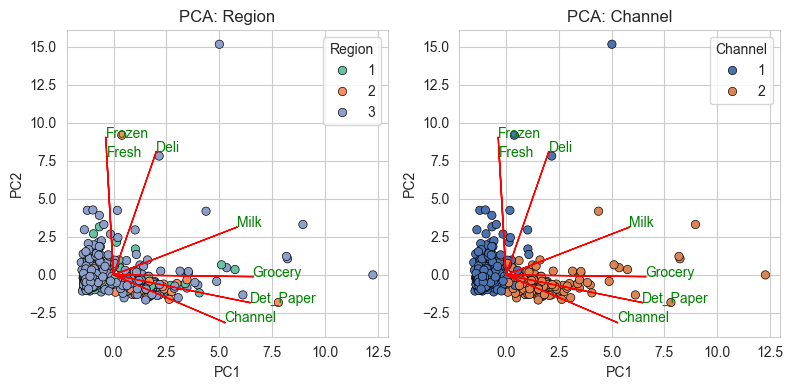

In [8]:
np.random.seed(42)
pca = PCA()

# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
var = pca.explained_variance_ratio_
feature_names = list(X.columns)

# PCA loadings
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
display(pca_loadings)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.set_style(style='whitegrid')
# scatter plot of PCA
sns.scatterplot(data=pca_X, x="PC1", y="PC2", hue=y.squeeze(), palette='Set2', edgecolor='black', ax=axes[0])

axes[0].set_title('PCA: Region')

# add PCA loadings as arrows
for i, feature in enumerate(feature_names):
    axes[0].arrow(0, 0, pca_loadings.PC1[i] * max(pca_X.PC1), pca_loadings.PC2[i] * max(pca_X.PC2), 
             head_width=0.05, head_length=0.05, color='red')
    axes[0].text(pca_loadings.PC1[i] * max(pca_X.PC1), pca_loadings.PC2[i] * max(pca_X.PC2), feature, color='green')

sns.set_style(style='whitegrid')
sns.scatterplot(pca_X, x="PC1", y="PC2", hue = X['Channel'], palette="deep", edgecolor='black', ax=axes[1])
axes[1].set_title('PCA: Channel')

for i, feature in enumerate(feature_names):
    axes[1].arrow(0, 0, pca_loadings.PC1[i] * max(pca_X.PC1), pca_loadings.PC2[i] * max(pca_X.PC2), 
             head_width=0.05, head_length=0.05, color='red')
    axes[1].text(pca_loadings.PC1[i] * max(pca_X.PC1), pca_loadings.PC2[i] * max(pca_X.PC2), feature, color='green')

plt.tight_layout()
plt.show()
#plt.savefig('./01_pca_analysis.png', dpi=300)

- The main features that drive the separation between PC1 and PC2 are {Fresh, Frozen, Deli} vs Others. Fresh and Frozen are closer together than Deli (2nd plot)
- The variance captured by the first two PCs is not effectively separating the clients by Region
- PC1 captures the variance that is most discriminative for the Channel feature
- It is likely that linear PCA decomposition with 2 PCs may be insuffient to distinguish the Regions

## t-SNE

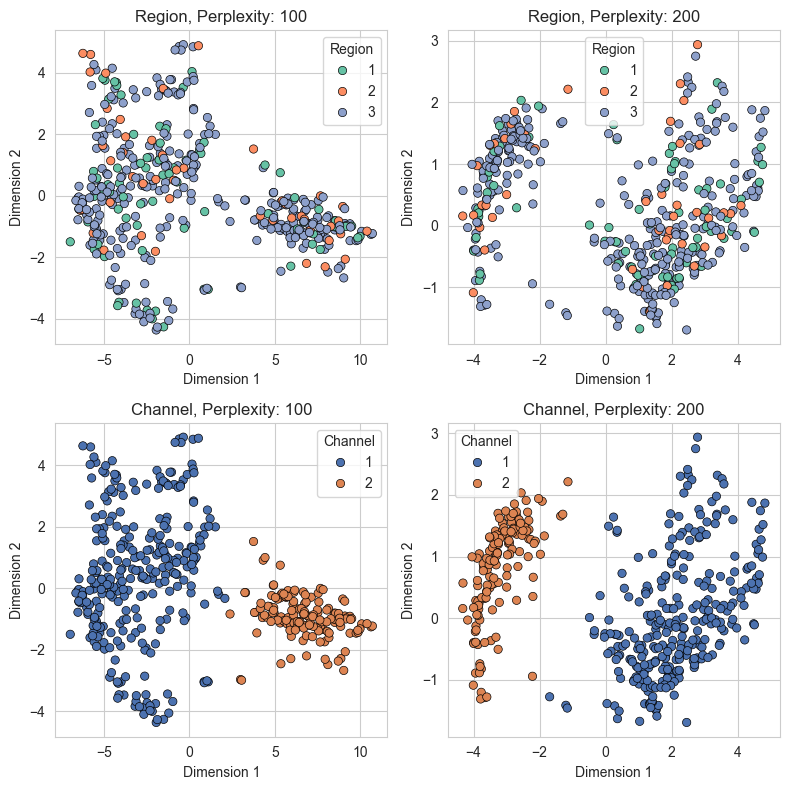

In [9]:
perplexities = [100, 200]
fig, axes = plt.subplots(2, len(perplexities), figsize=(8, 8))

for i, perplexity in enumerate(perplexities):
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=42)
    tsne_X_scaled = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])

    ax = axes[0,i]
    sns.scatterplot(data=tsne_X_scaled, x="Dim1", y="Dim2", hue=y.squeeze(), palette="Set2", ax=ax, edgecolor='black').set_title(f'Region, Perplexity: {perplexity}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    ax = axes[1,i]
    sns.scatterplot(data=tsne_X_scaled, x="Dim1", y="Dim2", hue=X['Channel'], palette="deep", ax=ax, edgecolor='black').set_title(f'Channel, Perplexity: {perplexity}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()
#plt.savefig('./02_tsne.png', dpi=300)

- perplexity of 100 should work well for k-means clustering as the points are closer to centroids  
- perplexity of 200 separate clusters well, but note some Channel 2 points being closer to Channel 1 when clustering points by density-based methods
- perplexity of 300 onwards result in tighter clusters, but there are more outlier points which may distort centroids (when using k-means) or become outliers in density-based methods
- adjusting perplexity does not help in identifying Region

In [10]:
# construct selected t-sne params
tsne = TSNE(n_components=2, perplexity=100, n_iter=300, random_state=42)
tsne_X_scaled_p100 = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])
tsne = TSNE(n_components=2, perplexity=200, n_iter=300, random_state=42)
tsne_X_scaled_p200 = pd.DataFrame(tsne.fit_transform(X_scaled), columns=['Dim1', 'Dim2'])

# 4. Clustering methods
## K-means clustering
### Determine optimal clusters with Silhouette method

In [11]:
ss_tsne100 = []; ss_tsne200 = []; kmax = 4

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(tsne_X_scaled_p100)
    labels = kmeans.labels_
    ss_tsne100.append(silhouette_score(tsne_X_scaled_p100, labels, metric = 'euclidean'))

    kmeans = KMeans(n_clusters = k, random_state = 42).fit(tsne_X_scaled_p200)
    labels = kmeans.labels_
    ss_tsne200.append(silhouette_score(tsne_X_scaled_p200, labels, metric = 'euclidean'))

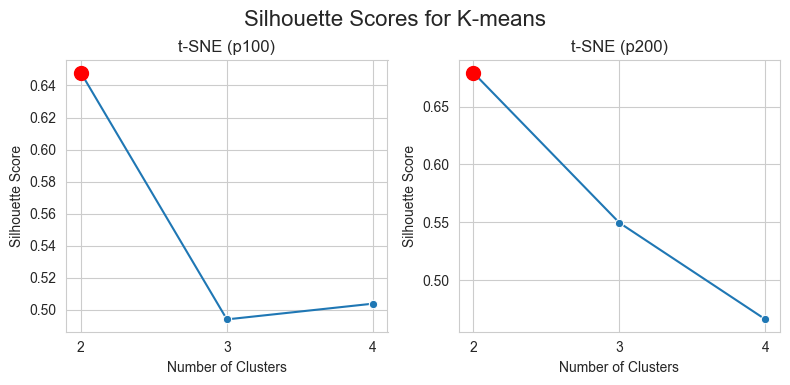

Best k for t-SNE (p100) data =  2 ; Silhouette Score:  0.648
Best k for t-SNE (p200) data =  2 ; Silhouette Score:  0.679


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Silhouette Scores for K-means', fontsize=16, y=0.95)


# silhoutte plot, p100
ax = axes[0]
sns.set_style(style='whitegrid')
sns.lineplot(x=range(2, kmax + 1), y=ss_tsne100, ax=ax, marker='o')
ax.set_title('t-SNE (p100)')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
max_y_100 = max(ss_tsne100)
max_x_100 = ss_tsne100.index(max_y_100) + 2  
ax.plot(max_x_100, max_y_100, 'ro', ms=10)

# silhoutte plot, p200
ax = axes[1]
sns.lineplot(x=range(2, kmax + 1), y=ss_tsne200, ax=ax, marker='o')
ax.set_title('t-SNE (p200)')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
max_y_200 = max(ss_tsne200)
max_x_200 = ss_tsne200.index(max_y_200) + 2 
ax.plot(max_x_200, max_y_200, 'ro', ms = 10)

plt.tight_layout()
plt.show()
#plt.savefig('./03_sil_score.png', dpi=300)
k_tsne100 = ss_tsne100.index(max(ss_tsne100)) + 2
print("Best k for t-SNE (p100) data = ", k_tsne100, "; Silhouette Score: ", round(max(ss_tsne100), 3))

k_tsne200 = ss_tsne200.index(max(ss_tsne200)) + 2
print("Best k for t-SNE (p200) data = ", k_tsne200, "; Silhouette Score: ", round(max(ss_tsne200), 3))

### Perform K-means clustering

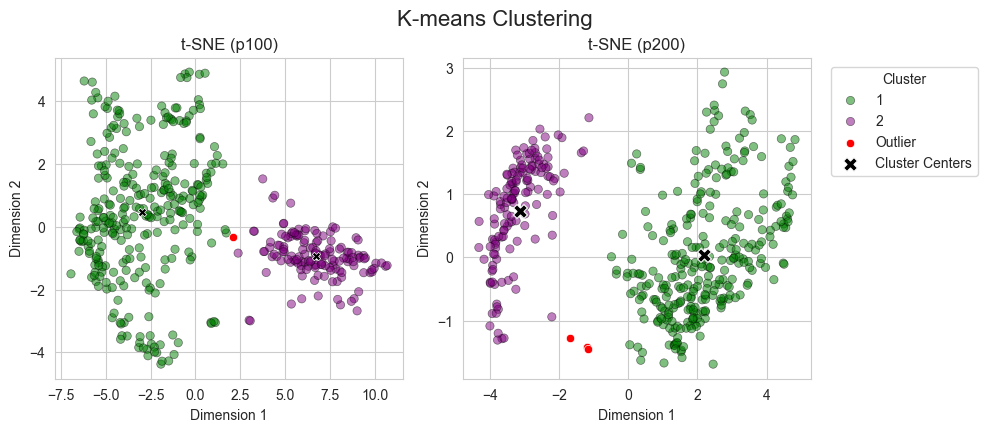

In [13]:
model = KMeans(n_clusters=k_tsne100, max_iter=1000, random_state=42)
model.fit(tsne_X_scaled_p100)
cluster_centers_tsne100 = model.cluster_centers_
labels_tsne100 = model.labels_

model = KMeans(n_clusters=k_tsne200, max_iter=1000, random_state=42)
model.fit(tsne_X_scaled_p200)
cluster_centers_tsne = model.cluster_centers_
labels_tsne200 = model.labels_

def map_and_compare(kmeans_labels, actual_labels):
    # KMeans 0 -> Channel 1, and KMeans 1 -> Channel 2
    mapped_labels = np.where(kmeans_labels == 0, 2, 1)
    misclassified = mapped_labels != actual_labels
    return misclassified, mapped_labels

misclassified_tsne100, mapped_labels_tsne100 = map_and_compare(labels_tsne100, X['Channel'].to_numpy())
misclassified_tsne200, mapped_labels_tsne200 = map_and_compare(labels_tsne200, X['Channel'].to_numpy())

tsne_X_scaled_p100['misclassified'] = misclassified_tsne100
tsne_X_scaled_p200['misclassified'] = misclassified_tsne200

palette = ['green', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle('K-means Clustering', fontsize=16, y=0.95)

# t-SNE (p100)
ax = axes[0]
# plot correct points
sns.scatterplot(data=tsne_X_scaled_p100[~tsne_X_scaled_p100['misclassified']], x="Dim1", y="Dim2", 
                hue=mapped_labels_tsne100[~tsne_X_scaled_p100['misclassified']], 
                palette=palette, alpha = 0.5,
                edgecolor='black', ax=ax, legend=None)
# plot misclassified points
sns.scatterplot(data=tsne_X_scaled_p100[tsne_X_scaled_p100['misclassified']], 
                x="Dim1", y="Dim2", color='red', 
                label='Misclassified', ax=ax , legend=None)
# cluster centers
sns.scatterplot(x=cluster_centers_tsne100[:, 0], y=cluster_centers_tsne100[:, 1], color='black', 
                label='Cluster Centers', marker='X', ax=ax, legend = None)


ax.set_title('t-SNE (p100)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# t-SNE (p200)
ax = axes[1]
# plot correct points
sns.scatterplot(data=tsne_X_scaled_p200[~tsne_X_scaled_p200['misclassified']], x="Dim1", y="Dim2", 
                hue=mapped_labels_tsne200[~tsne_X_scaled_p200['misclassified']], palette=palette, alpha = 0.5, 
                edgecolor='black')
# plot misclassified points
sns.scatterplot(data=tsne_X_scaled_p200[tsne_X_scaled_p200['misclassified']], x="Dim1", y="Dim2", 
                color='red', label='Outlier', ax=ax, legend=None)
# cluster centers
sns.scatterplot(x=cluster_centers_tsne[:, 0], y=cluster_centers_tsne[:, 1], color='black', label='Cluster Centers', marker='X', s=100, ax=ax)
ax.legend(title = 'Cluster', loc='right', bbox_to_anchor=(1.5, 0.8))
ax.set_title('t-SNE (p200)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()
#plt.savefig('./04_kmeans_results.png', dpi=300)

In [14]:
kmeans_result_p100 = tsne_X_scaled_p100
kmeans_result_p200 = tsne_X_scaled_p200

mis100 = tsne_X_scaled_p100['misclassified'].sum() 

# summary for p100
summary_results_p100 = pd.DataFrame({
    'Parameters' : ['k clusters', 'Silhouette score', 'Number of outlier', 'min_samples', 'epsilon'],
    'K-means': [2, round(max(ss_tsne100), 3), mis100, '-', '-']
})

mis200 = tsne_X_scaled_p200['misclassified'].sum()

# summary for p200
summary_results_p200 = pd.DataFrame({
    'Parameters' : ['k clusters', 'Silhouette score', 'Number of outlier', 'min_samples', 'epsilon'],
    'K-means': [2, round(max(ss_tsne200), 3), mis200, '-', '-']
})

display(summary_results_p100)
display(summary_results_p200)

,Parameters,K-means
0,k clusters,2
1,Silhouette score,0.65
2,Number of outlier,1
3,min_samples,-
4,epsilon,-


,Parameters,K-means
0,k clusters,2
1,Silhouette score,0.68
2,Number of outlier,3
3,min_samples,-
4,epsilon,-


## Agglomerative Hierarchical Clustering

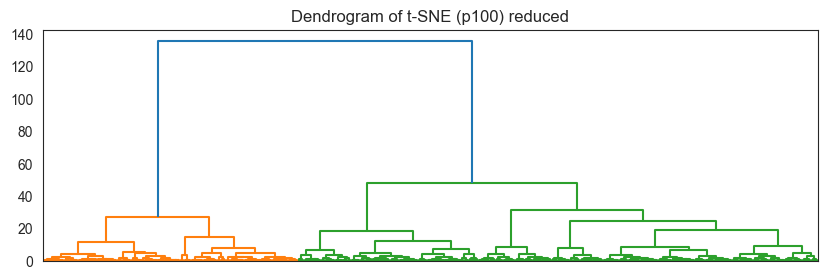

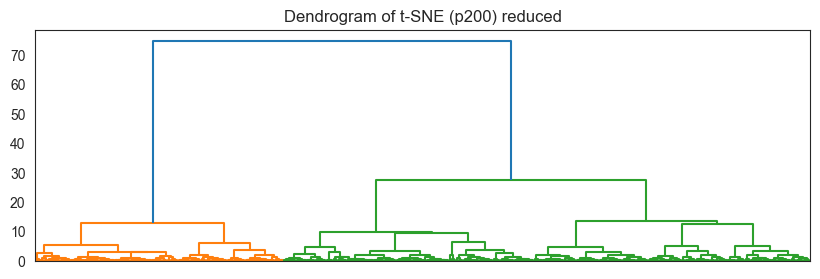

In [15]:
# visualize the dendrograms
hclust_tsne_p100 = linkage(tsne_X_scaled_p100, 'ward')
hclust_tsne_p200 = linkage(tsne_X_scaled_p200, 'ward')

sns.set_style(style='white')

plt.figure(figsize=(10,3))
dn = dendrogram(hclust_tsne_p100)
plt.title("Dendrogram of t-SNE (p100) reduced")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.figure(figsize=(10,3))
dn = dendrogram(hclust_tsne_p200)
plt.title("Dendrogram of t-SNE (p200) reduced")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

### Determine optimal clusters with Silhouette method 

In [16]:
ss_tsne100 = []; ss_tsne200 = []; kmax = 4

for k in range(2, kmax + 1):
    Aggc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit(tsne_X_scaled_p100)
    labels = Aggc.labels_
    ss_tsne100.append(silhouette_score(tsne_X_scaled_p100, labels, metric = 'euclidean'))

    Aggc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit(tsne_X_scaled_p200)
    labels = Aggc.labels_
    ss_tsne200.append(silhouette_score(tsne_X_scaled_p200, labels, metric = 'euclidean'))

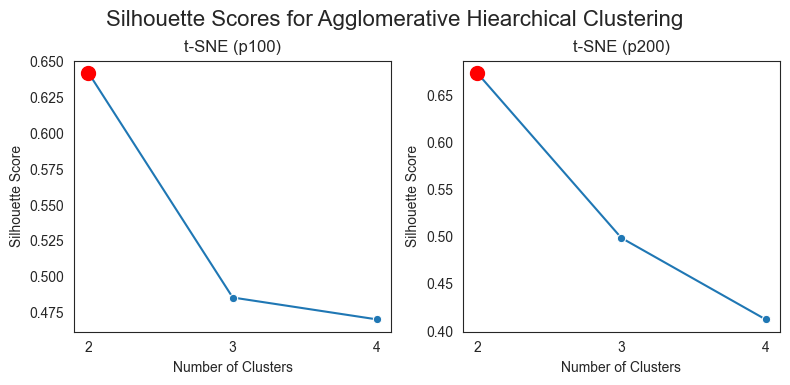

Best k for t-SNE (p100) data =  2 ; Silhouette Score:  0.642
Best k for t-SNE (p200) data =  2 ; Silhouette Score:  0.674


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Silhouette Scores for Agglomerative Hiearchical Clustering', fontsize=16, y=0.95)

# silhoutte plot, p100
ax = axes[0]
sns.set_style(style='whitegrid')
sns.lineplot(x=range(2, kmax + 1), y=ss_tsne100, ax=ax, marker='o')
ax.set_title('t-SNE (p100)')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
max_y_100 = max(ss_tsne100)
max_x_100 = ss_tsne100.index(max_y_100) + 2 
ax.plot(max_x_100, max_y_100, 'ro', ms=10)

# silhoutte plot, p200
ax = axes[1]
sns.set_style(style='whitegrid')
sns.lineplot(x=range(2, kmax + 1), y=ss_tsne200, ax=ax, marker='o')
ax.set_title('t-SNE (p200)')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
max_y_200 = max(ss_tsne200)
max_x_200 = ss_tsne200.index(max_y_200) + 2 
ax.plot(max_x_200, max_y_200, 'ro', ms = 10)

plt.tight_layout()
plt.show()
#plt.savefig('./05_sil_score_hac.png', dpi=300)
k_tsne100 = ss_tsne100.index(max(ss_tsne100)) + 2
print("Best k for t-SNE (p100) data = ", k_tsne100, "; Silhouette Score: ", round(max(ss_tsne100), 3))

k_tsne200 = ss_tsne200.index(max(ss_tsne200)) + 2
print("Best k for t-SNE (p200) data = ", k_tsne200, "; Silhouette Score: ", round(max(ss_tsne200), 3))

### Perform AHC

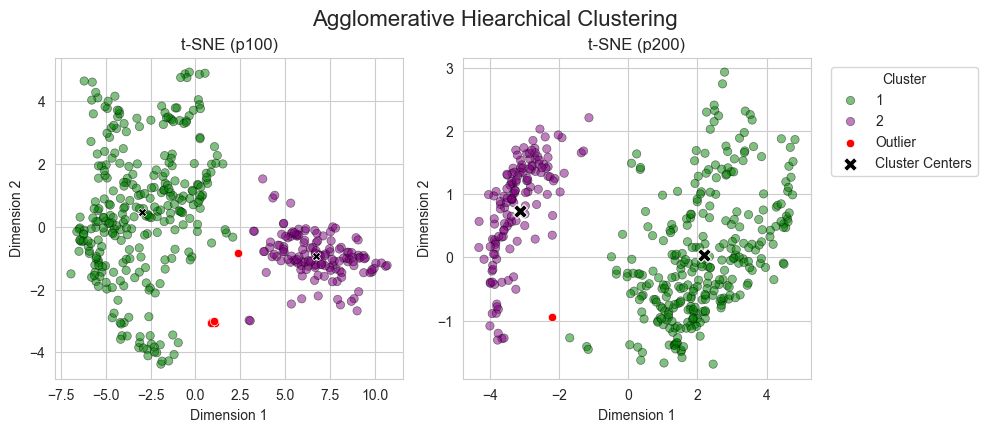

In [18]:
clusters_tsne_p100 = fcluster(hclust_tsne_p100, k_tsne100, criterion='maxclust')
clusters_tsne_p200 = fcluster(hclust_tsne_p200, k_tsne200, criterion='maxclust')

def map_and_compare(kmeans_labels, actual_labels):
    # Mapping: KMeans 0 -> Channel 1, and KMeans 1 -> Channel 2
    mapped_labels = np.where(kmeans_labels == 1, 2, 1)
    misclassified = mapped_labels != actual_labels
    return misclassified, mapped_labels


misclassified_tsne100, mapped_labels_tsne100 = map_and_compare(clusters_tsne_p100, X['Channel'].to_numpy())
misclassified_tsne200, mapped_labels_tsne200 = map_and_compare(clusters_tsne_p200, X['Channel'].to_numpy())

tsne_X_scaled_p100['misclassified'] = misclassified_tsne100
tsne_X_scaled_p200['misclassified'] = misclassified_tsne200

palette = ['green', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle('Agglomerative Hiearchical Clustering', fontsize=16, y=0.95)

# t-SNE (p100)
ax = axes[0]
# plot correct points
sns.scatterplot(data=tsne_X_scaled_p100[~tsne_X_scaled_p100['misclassified']], x="Dim1", y="Dim2", 
                hue=mapped_labels_tsne100[~tsne_X_scaled_p100['misclassified']], 
                palette=palette, alpha = 0.5,
                edgecolor='black', ax=ax, legend=None)
# plot misclassified points
sns.scatterplot(data=tsne_X_scaled_p100[tsne_X_scaled_p100['misclassified']], 
                x="Dim1", y="Dim2", color='red', 
                label='Outlier', ax=ax , legend=None)
# cluster centers
sns.scatterplot(x=cluster_centers_tsne100[:, 0], y=cluster_centers_tsne100[:, 1], color='black', 
                label='Cluster Centers', marker='X', ax=ax, legend = None)


ax.set_title('t-SNE (p100)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# t-SNE (p200)
ax = axes[1]
# plot correct points
sns.scatterplot(data=tsne_X_scaled_p200[~tsne_X_scaled_p200['misclassified']], x="Dim1", y="Dim2", 
                hue=mapped_labels_tsne200[~tsne_X_scaled_p200['misclassified']], palette=palette, alpha = 0.5, 
                edgecolor='black')
# plot misclassified points
sns.scatterplot(data=tsne_X_scaled_p200[tsne_X_scaled_p200['misclassified']], x="Dim1", y="Dim2", 
                color='red', label='Outlier', ax=ax, legend=None)
# cluster centers
sns.scatterplot(x=cluster_centers_tsne[:, 0], y=cluster_centers_tsne[:, 1], color='black', label='Cluster Centers', marker='X', s=100, ax=ax)
ax.legend(title = 'Cluster', loc='right', bbox_to_anchor=(1.5, 0.8))
ax.set_title('t-SNE (p200)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()
#plt.savefig('./06_hac_results.png', dpi=300)

In [19]:
hac_result_p100 = tsne_X_scaled_p100
hac_result_p200 = tsne_X_scaled_p200

mis100 = tsne_X_scaled_p100['misclassified'].sum()
summary_results_p100['HAC'] = [2, round(max(ss_tsne100), 3), mis100, '-', '-']

mis200 = tsne_X_scaled_p200['misclassified'].sum()
summary_results_p200['HAC'] = [2, round(max(ss_tsne200), 3), mis200, '-', '-']

display(summary_results_p100)
display(summary_results_p200)

,Parameters,K-means,HAC
0,k clusters,2,2
1,Silhouette score,0.65,0.64
2,Number of outlier,1,5
3,min_samples,-,-
4,epsilon,-,-


,Parameters,K-means,HAC
0,k clusters,2,2
1,Silhouette score,0.68,0.67
2,Number of outlier,3,1
3,min_samples,-,-
4,epsilon,-,-


## DBSCAN
### Perform k-distance graph

In [20]:
min_samples_tsne = 2*len(tsne_X_scaled_p100.columns)
print('min_samples for tsne data: ', min_samples_tsne)
NN_tsne = min_samples_tsne - 1
print('Nearest neighbours for tsne data: ', NN_tsne)

min_samples for tsne data:  6
Nearest neighbours for tsne data:  5


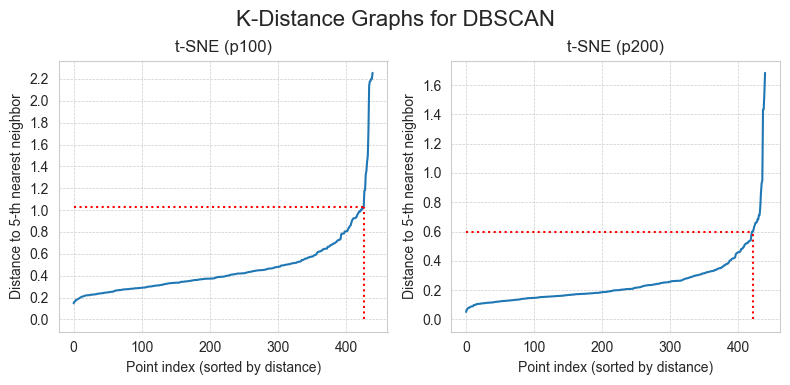

In [21]:
# distance to the k-th nearest neighbor
neigh = NearestNeighbors(n_neighbors=NN_tsne)
neigh.fit(tsne_X_scaled_p100)
distances, indices = neigh.kneighbors(tsne_X_scaled_p100)
sorted_distances = np.sort(distances[:, NN_tsne-1], axis=0)

tsne_p100_k_distance = pd.DataFrame({
    'Point Index': range(len(sorted_distances)),
    f'Distance to {NN_tsne}-th Nearest Neighbor': sorted_distances
})

neigh = NearestNeighbors(n_neighbors=NN_tsne)
neigh.fit(tsne_X_scaled_p200)
distances, indices = neigh.kneighbors(tsne_X_scaled_p200)
sorted_distances = np.sort(distances[:, NN_tsne-1], axis=0)

tsne_p200_k_distance = pd.DataFrame({
    'Point Index': range(len(sorted_distances)),
    f'Distance to {NN_tsne}-th Nearest Neighbor': sorted_distances
})

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('K-Distance Graphs for DBSCAN', fontsize=16, y=0.95)

ax = axes[0]

target = 1.1
closest_row = tsne_p100_k_distance.iloc[(tsne_p100_k_distance['Distance to 5-th Nearest Neighbor'] - target).abs().argsort()[:1]]
closest_x = closest_row['Point Index'].values[0]
closest_y = closest_row['Distance to 5-th Nearest Neighbor'].values[0]

sns.lineplot(data=tsne_p100_k_distance, x='Point Index', y=f'Distance to {NN_tsne}-th Nearest Neighbor', ax=ax)
ax.plot([closest_x, closest_x], [0, closest_y], color='r', linestyle=':', label=f'X to {closest_x}')
ax.plot([0, closest_x], [closest_y, closest_y], color='r', linestyle=':', label=f'Y to {closest_y}')
ax.set_title('t-SNE (p100)')
ax.set_xlabel('Point index (sorted by distance)')
ax.set_ylabel(f'Distance to {NN_tsne}-th nearest neighbor')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_locator(MultipleLocator(0.2))

ax = axes[1]
target = 0.6
closest_row = tsne_p200_k_distance.iloc[(tsne_p200_k_distance['Distance to 5-th Nearest Neighbor'] - target).abs().argsort()[:1]]
closest_x = closest_row['Point Index'].values[0]
closest_y = closest_row['Distance to 5-th Nearest Neighbor'].values[0]

sns.lineplot(data=tsne_p200_k_distance, x='Point Index', y=f'Distance to {NN_tsne}-th Nearest Neighbor', ax=ax)
ax.plot([closest_x, closest_x], [0, closest_y], color='r', linestyle=':', label=f'X to {closest_x}')
ax.plot([0, closest_x], [closest_y, closest_y], color='r', linestyle=':', label=f'Y to {closest_y}')
ax.set_title('t-SNE (p200)')
ax.set_xlabel('Point index (sorted by distance)')
ax.set_ylabel(f'Distance to {NN_tsne}-th nearest neighbor')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_locator(MultipleLocator(0.2))

plt.tight_layout()
plt.show()
#plt.savefig('./07_kdist.png', dpi=300)

- for t-SNE p100 reduced data, the epsilon value is ~ 1.1
- for t-SNE p200 reduced data, the epsilon value is ~ 0.6

In [22]:
def optimise_dbscan_params(data, min_samples, eps):
    
    data = data 
    # parameters for epsilon and min_samples
    eps_range = np.linspace(eps, 4, 6)
    min_samples_range = range(min_samples, 35) 
    
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(data)

            core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
            core_samples_mask[model.core_sample_indices_] = True
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_outliers = list(labels).count(-1)
            
            if 1 < n_clusters < len(data) - 1:
                silhouette_avg = silhouette_score(data, labels)
                n_outliers = np.sum(labels == -1)         
                
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'silhouette_score': silhouette_avg,
                    'number_of_clusters': n_clusters,
                    'number_of_outliers': n_outliers,
                })
        
    results_df = pd.DataFrame(results)
    return(results_df)

In [23]:
tsne_p100_res=optimise_dbscan_params(tsne_X_scaled_p100, min_samples=min_samples_tsne, eps = 1) 
tsne_p200_res=optimise_dbscan_params(tsne_X_scaled_p200, min_samples=min_samples_tsne, eps = 0.7) 
print("tSNE p100:")

filtered = tsne_p100_res[tsne_p100_res['silhouette_score'] > 0.4]
top_rows = filtered.sort_values(by=['number_of_outliers', 'silhouette_score'], ascending=[True, False]).head(3)
num_k_100 = top_rows['number_of_clusters'].iloc[0]
eps_p100 = top_rows['eps'].iloc[0]
ss_p100 = top_rows['silhouette_score'].iloc[0]
min_samples_p100 = top_rows['min_samples'].iloc[0]
display(top_rows)

print("tSNE p200:")
filtered = tsne_p200_res[tsne_p200_res['silhouette_score'] > 0.4]
top_rows = filtered.sort_values(by=['number_of_outliers', 'silhouette_score'], ascending=[True, False]).head(3)
num_k_200 = top_rows['number_of_clusters'].iloc[0]
eps_p200 = top_rows['eps'].iloc[0]
ss_p200 = top_rows['silhouette_score'].iloc[0]
min_samples_p200 = top_rows['min_samples'].iloc[0]
display(top_rows)

tSNE p100:


,eps,min_samples,silhouette_score,number_of_clusters,number_of_outliers
57,2.20,34,0.41,2,4
55,2.20,32,0.41,2,4
56,2.20,33,0.41,2,4


tSNE p200:


,eps,min_samples,silhouette_score,number_of_clusters,number_of_outliers
29,1.36,6,0.52,2,2
30,1.36,7,0.52,2,2
31,1.36,8,0.52,2,2


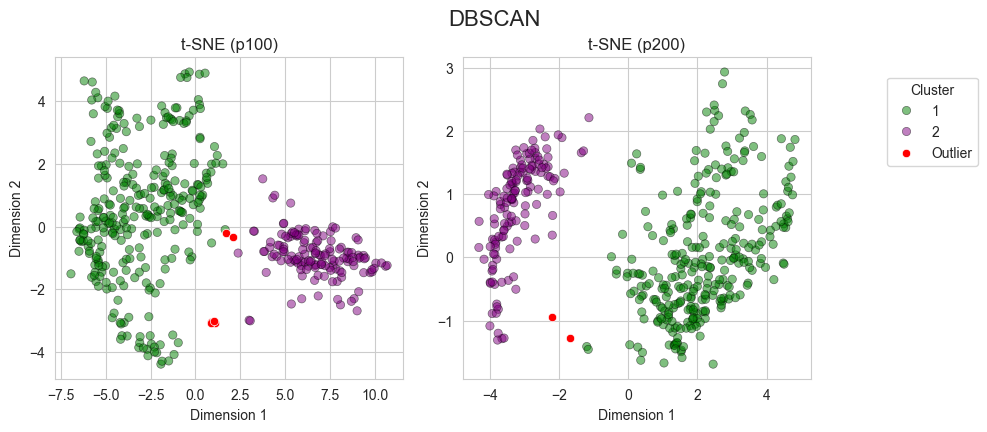

In [24]:
X_dbscanp100 = tsne_X_scaled_p100
optimal_model_100 = DBSCAN(eps=eps_p100, min_samples=34)
optimal_labels_100 = optimal_model_100.fit_predict(X_dbscanp100)
#X_dbscanp100['Cluster'] = optimal_labels_100

X_dbscanp200 = tsne_X_scaled_p200
optimal_model_200 = DBSCAN(eps=eps_p200, min_samples=6)
optimal_labels_200 = optimal_model_200.fit_predict(X_dbscanp200)
#X_dbscanp200['Cluster'] = optimal_labels_200

def map_and_compare(optimal_labels, actual_labels):
    mapped_labels = np.where(optimal_labels == 0, 2, optimal_labels)
    # Identifying misclassified points
    misclassified = mapped_labels != actual_labels
    return misclassified, mapped_labels

# Applying the function for each t-SNE reduced data
misclassified_tsne100, mapped_labels_tsne100 = map_and_compare(optimal_labels_100, X['Channel'].to_numpy())
misclassified_tsne200, mapped_labels_tsne200 = map_and_compare(optimal_labels_200, X['Channel'].to_numpy())

# Adding misclassified information to the data for plotting
X_dbscanp100['misclassified'] = misclassified_tsne100
X_dbscanp200['misclassified'] = misclassified_tsne200

palette = ['green', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle('DBSCAN', fontsize=16, y=0.95)

# t-SNE (p100)
ax = axes[0]
# Plot correctly classified points
sns.scatterplot(data=X_dbscanp100[~X_dbscanp100['misclassified']], x="Dim1", y="Dim2", 
                hue=mapped_labels_tsne100[~X_dbscanp100['misclassified']], 
                palette=palette, alpha = 0.5,
                edgecolor='black', ax=ax, legend=None)
# Plot misclassified points
sns.scatterplot(data=X_dbscanp100[X_dbscanp100['misclassified']], 
                x="Dim1", y="Dim2", color='red', 
                label='Outlier', ax=ax , legend=None)
ax.set_title('t-SNE (p100)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# t-SNE (p200)
ax = axes[1]
# Plot correctly classified points

sns.scatterplot(data=X_dbscanp200[~X_dbscanp200['misclassified']], x="Dim1", y="Dim2", 
                hue=mapped_labels_tsne200[~X_dbscanp200['misclassified']], palette=palette, alpha = 0.5, 
                edgecolor='black')
# Plot misclassified points
sns.scatterplot(data=X_dbscanp200[X_dbscanp200['misclassified']], x="Dim1", y="Dim2", 
                color='red', label='Outlier', ax=ax, legend=None)
ax.legend(title = 'Cluster', loc='right', bbox_to_anchor=(1.5, 0.8))
ax.set_title('t-SNE (p200)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

plt.tight_layout()
#plt.show()
plt.savefig('./08_dbscan.png', dpi=300)

In [25]:
dbscan_result_p100 = X_dbscanp100
dbscan_result_p200 = X_dbscanp200

mis100 = X_dbscanp100['misclassified'].sum()
summary_results_p100['DBSCAN'] = [num_k_100, round(ss_p100, 3), mis100, min_samples_p100, eps_p100]


mis200 = X_dbscanp200['misclassified'].sum()
summary_results_p200['DBSCAN'] = [num_k_200, round(ss_p200, 3), mis200, min_samples_p200, eps_p200]

display(summary_results_p100)
display(summary_results_p200)

,Parameters,K-means,HAC,DBSCAN
0,k clusters,2,2,2.00
1,Silhouette score,0.65,0.64,0.41
2,Number of outlier,1,5,6.00
3,min_samples,-,-,34.00
4,epsilon,-,-,2.20


,Parameters,K-means,HAC,DBSCAN
0,k clusters,2,2,2.00
1,Silhouette score,0.68,0.67,0.52
2,Number of outlier,3,1,2.00
3,min_samples,-,-,6.00
4,epsilon,-,-,1.36
